# Chapter 3
## Lab: Linear Regression


We need the Boston data set as before



In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.datasets import load_boston
from sklearn import linear_model, metrics
import scipy.stats
# NB could also use scipy.linalg.lstsq, 
# which sklearn's LinearRegression is a wrapper for
sns.set(style="whitegrid")

In [5]:
boston = load_boston()
headers = ["CRIM", "ZN", "INDUS", "CHAS", "NOX",
           "RM", "AGE", "DIS", "RAD", "TAX",
           "PTRATIO", "B", "LSTAT", "MEDV"]
boston_array = np.concatenate((boston.data, boston.target[:, np.newaxis]), axis=1)

boston_dataframe = pd.DataFrame(data=boston_array, columns=headers)
boston_dataframe.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
# Maybe I should show the Python-data-science version, and also implement my own version?

**Fit a simple linear regression model, with MEDV as the response and LSTAT as the predictor**

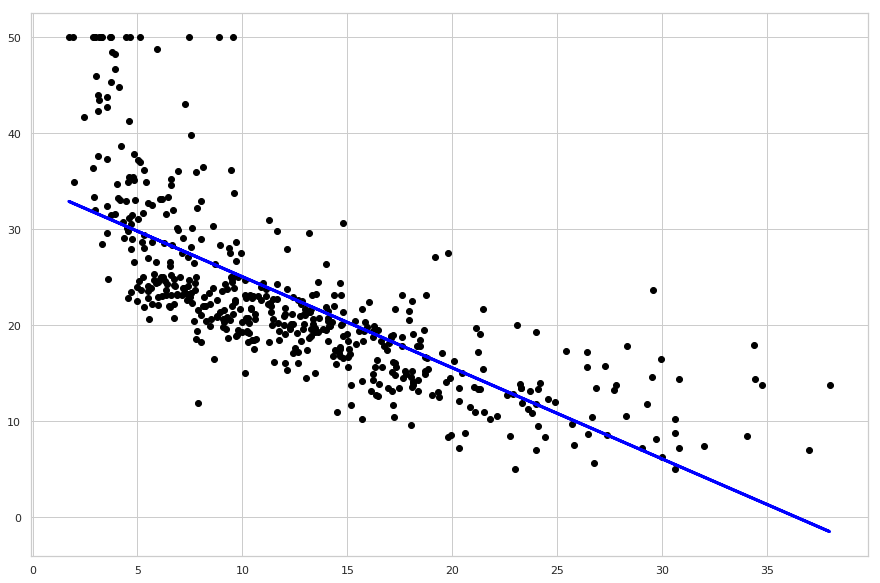

In [71]:

regr = sklearn.linear_model.LinearRegression()

# The X_train needs to be 2D to work with sklearn 
x_train = boston_dataframe.LSTAT.to_numpy().reshape(-1, 1)
y_train = boston_dataframe.MEDV
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_train)

# Plot the fit
fig, ax = plt.subplots(figsize=(15,10))
plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, y_pred, color='blue', linewidth=3)
plt.show()

Coefficient: -0.95
Intercept: 34.55


In [120]:
def getRSS(y_train, y_pred):
    """
    Given a 1D array of observed and predicted y values,
    calculate the sum of the square distances between the elements.
    """
    assert len(y_train) == len(y_pred)
    return np.sum(np.square(y_train - y_pred))
    
def getRSE(y_train, y_pred):
    """
    RSE (Residual Standard Error) roughly gives the average 
    amount that the response will deviate from the true regression
    line, due to the error terms \epsilon (irreducible error),
    i.e. RSE ~ \sigma, where sigma^2 = Var(\epsilon)
    RSE ~ sqrt(RSS/n-2), where RSS is the residual sum of squares.
    """
    assert len(y_train) == len(y_pred)  
    RSS = getRSS(y_train, y_pred)
    n = len(y_train)
    return math.sqrt(RSS/(n-2))
    
    

def getStdErrorsFromLinearRegression(x_train, y_train, y_pred):
    """
    The std error in the intercept is
    
    SE(B_0)^2 = sigma^2 * (1/n + x_mean^2/sum((x_i - x_mean)^2)
    
    The std error in the first coefficient is
    
    SE(B_1)^2 = sigma^2/sum((x_i - x_mean)^2)
    
    where sigma is roughly the RSE
    """
    x_mean = np.mean(x_train)
    sigma  = getRSE(y_train, y_pred)
    n = len(x_train)
    SE_B0 = math.sqrt(sigma**2 * (1/n + x_mean**2/np.sum(np.square(x_train-x_mean))))
    SE_B1 = math.sqrt(sigma**2 / np.sum(np.square(x_train-x_mean)))
    
    return SE_B0, SE_B1

def getTStatisticForCoefficient(coefficient, std_error):
    """
    This is the number of standard deviations that the coefficient is away from 0.
    """
    return coefficient/std_error

def getPValueForCoefficient(t, n):
    """
    If there's no relationship between X and Y, we expect the t-statistic given above to 
    have a t-distribution with n-2 degrees of freedom (roughly a normal dist.)
    """
    p = 1 - scipy.stats.t.cdf(t,df=n-2)
    if t > 0:
        return p
    else:
        return 1-p

In [123]:
# The coefficients of the fit
B1 = regr.coef_[0]
B0 = regr.intercept_
print(f'B_0 (intercept): {B0:.2f}  B_1 (gradient): {B1:.2f}')

# p-values and standard errors for the coefficients
SE_B0, SE_B1 = getStdErrorsFromLinearRegression(x_train, y_train, y_pred)
print(f"Standard errors in the coefficients: {SE_B0:.2f}, {SE_B1:.2f}")

t_B0 = getTStatisticForCoefficient(B0, SE_B0)
t_B1 = getTStatisticForCoefficient(B1, SE_B1)
print(f"t-statistic for these errors: {t_B0:.2f}, {t_B1:.2f}")


p_B0 = getPValueForCoefficient(t_B0, len(x_train))
p_B1 = getPValueForCoefficient(t_B1, len(x_train))
print(f"Associated p-values: {p_B0:.5f}, {p_B1:.5f}")

B_0 (intercept): 34.55  B_1 (gradient): -0.95
Standard errors in the coefficients: 0.56, 0.04
t-statistic for these errors: 61.42, -24.53
Associated p-values: 0.00000, 0.00000


In [135]:
def getTSS(y_train, y_pred):
    """
    TSS is the total sum of squares sum(y_i - y_mean)^2 
    """
    y_mean = np.mean(y_train)
    TSS = np.sum(np.square(y_train - y_mean))
    return TSS
    
def getR2(y_train, y_pred):
    """
    The fraction of the variance explained by the data.
    R2 = (TSS-RSS)/TSS
    """
    RSS =getRSS(y_train, y_pred)
    TSS = getTSS(y_train, y_pred)
    return 1 - RSS/TSS

def getFStatistic(y_train, y_pred, p):
    """
    The f-statistic is used to test the null hypothesis that all coefficients in the
    model are zero.
    
    F = ( (TSS-RSS)/p ) / ( RSS/(n-p-1) ) where p is the number of features/predictors
    """
    TSS = getTSS(y_train, y_pred)
    RSS = getRSS(y_train, y_pred)
    n = len(y_train)
    F = ( (TSS-RSS)/p ) / ( RSS/(n-p-1) )
    return F

def getPValueGivenFStatistic(F, n, p):
    """
    Given that the null hypothesis is true that all coefficients are zero,
    and the errors are normally distributed, we expect F to follow an F-distribution.
    """
    
    p = 1 - scipy.stats.f.cdf(F, p, n)
    return p
    

In [136]:
# Properties of the model itself: 
# RSE
print(f"Residual standard error: {getRSE(y_train, y_pred):.2f}")

#The R^2 statistic
R2 =  getR2(y_train, y_pred)
print(f'R2 score (i.e fraction of variance explained): {R2:.2f}')

# The F-statistic for the model
p=1
F = getFStatistic(y_train, y_pred, p)
print(f"F-statistic for the model: {F:.2f}")

p_F = getPValueGivenFStatistic(F, len(x_train), p)
print(f"Associated p-value: {p_F:.2f}")


Residual standard error: 6.22
R2 score (i.e fraction of variance explained): 0.54
F-statistic for the model: 601.62
Associated p-value: 0.00


In [140]:
"""
Confidence intervals for the coefficients: 

Roughly coeff +- 2* standard_error 
(it's not quite 2, isn't the 97.5th quantile of a t-distribution with n-2 DoF)
"""
confidence_b0 = (B0 - 2*SE_B0, B0 + 2*SE_B0)
confidence_b1 = (B1 - 2*SE_B1, B1 + 2*SE_B1)
print(f"confidence interval for B0: {confidence_b0}")
print(f"confidence interval for B1: {confidence_b1}")



confidence interval for B0: (33.428586169406245, 35.679095589359974)
confidence interval for B1: (-1.0275161861832698, -0.8725825213327121)


In [148]:
# Using these, we can get confidence intervals for our values
# Whats the difference between confidence and prediction intervals?

def getUpperLimit(confidence_b0, confidence_b1, x_value):
    return 

print(regr.predict([[5],[10],[15]]))
print([confidence_b0[1] + confidence_b1[0]*x_value for x_value in [5,10,15]])
print([confidence_b0[0] + confidence_b1[1]*x_value for x_value in [5,10,15]])


[29.80359411 25.05334734 20.30310057]
[30.541514658443624, 25.403933727527274, 20.266352796610928]
[29.065673562742685, 24.702760956079125, 20.33984834941556]
